In [1]:
import numpy as np
import argparse

import tensorflow.keras as tk


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Reshape,Conv2D, Conv2DTranspose, UpSampling2D, Input
from tensorflow.keras.layers import LeakyReLU, Dropout,BatchNormalization
from tensorflow.keras.optimizers import RMSprop

import matplotlib
import matplotlib.pyplot as plt

In [2]:
def plotImages(G,sauve=False, fake=True, nb=16, noise=None, step=0):
    filename = 'mnist.png'
    if fake:
        if noise is None:
            noise = np.random.uniform(-1.0, 1.0, size=[nb, 100])
        else:
            filename = "./images/mnist_%d.png" % step
        images = G.predict(noise)
    else:
        i = np.random.randint(0, x_train.shape[0], nb)
        images = x_train[i, :, :, :]

    plt.figure(figsize=(10,10))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [taille_image, taille_image])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    if sauve:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

In [3]:
(x_train, y_train), (x_test, y_test) =tk.datasets.mnist.load_data()



num_examples = x_train.shape[0] 
num_input = x_train.shape[1]*x_train.shape[2]
num_classes = 10
x_train = x_train.reshape(-1, x_train.shape[1],x_train.shape[2],1).astype(np.float32)/255
x_test = x_test.reshape(-1, x_test.shape[1],x_test.shape[2],1).astype(np.float32)/255




In [4]:
numEpochs = 2000
tailleBatch = 128
dropout = 0.5
nb_filtres = 64
latentDim = 100
taille_image = 28


In [5]:
def discriminant():
    #TODO
    D = Sequential()
    D.add(Input(shape=(taille_image, taille_image, 1)))
    D.add(Conv2D(nb_filtres, kernel_size=5, strides=2, padding='same'))
    D.add(LeakyReLU(negative_slope=0.2))
    D.add(Dropout(dropout))
    D.add(Conv2D(2*nb_filtres, kernel_size=5, strides=2, padding='same'))
    D.add(BatchNormalization())
    D.add(LeakyReLU(negative_slope=0.2))
    D.add(Dropout(dropout))
    D.add(Flatten())
    D.add(Dense(1, activation='sigmoid'))

    return D

In [6]:
#Réseau générateur
def generateur():
    #TODO
    
    G = Sequential()
    G.add(Input(shape=(latentDim,)))
    G.add(Dense(7*7*nb_filtres*2))  # 初始化 dense
    G.add(Reshape((7, 7, nb_filtres*2)))  # 将其 reshape 成卷积输入
    G.add(BatchNormalization(momentum=0.9))
    G.add(LeakyReLU(negative_slope=0.2))

    G.add(Conv2DTranspose(nb_filtres, kernel_size=5, strides=2, padding='same'))
    G.add(BatchNormalization(momentum=0.9))
    G.add(LeakyReLU(negative_slope=0.2))

    G.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='sigmoid'))
    
    return G

In [7]:
def adversarial():
    #TODO : construire le réseau GAN à partir de G et D
    # 构建生成器和判别器
    G = generateur()
    D = discriminant()

    # 冻结判别器权重
    D.trainable = False

    # 构建对抗模型
    A = Sequential()
    A.add(G)
    A.add(D)


    return A


In [8]:

def myGAN(D,A,G):

    D.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    A.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    noise_input = None
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
 
    for i in range(int(numEpochs/tailleBatch)):
        images_train = x_train[np.random.randint(0,x_train.shape[0], size=tailleBatch), :, :, :]
        noise = np.random.uniform(-1.0, 1.0, size=[tailleBatch, 100])
        images_fake = G.predict(noise)
        x = np.concatenate((images_train, images_fake))
        y = np.ones([2*tailleBatch, 1])
        y[tailleBatch:, :] = 0
        d_loss = D.train_on_batch(x, y)

        y = np.ones([tailleBatch, 1])
        noise = np.random.uniform(-1.0, 1.0, size=[tailleBatch, 100])
        a_loss = A.train_on_batch(noise, y)
        log_mesg = "Iter %d [perte D = %f, précision D = %f]/[perte A= %f, précision A= %f]" % (i, d_loss[0], d_loss[1],a_loss[0], a_loss[1])
        print(log_mesg)

        

2024-11-25 17:01:36.482226: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-11-25 17:01:36.482242: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-25 17:01:36.482249: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-25 17:01:36.482262: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-25 17:01:36.482272: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


2024-11-25 17:01:37.754415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Iter 0 [perte D = 0.744368, précision D = 0.539062]/[perte A= 0.662800, précision A= 0.851562]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Iter 1 [perte D = 0.392830, précision D = 0.765625]/[perte A= 0.651146, précision A= 0.894531]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Iter 2 [perte D = 0.263560, précision D = 0.843750]/[perte A= 0.644846, précision A= 0.924479]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Iter 3 [perte D = 0.198010, précision D = 0.882812]/[perte A= 0.638299, précision A= 0.939453]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Iter 4 [perte D = 0.158482, précision D = 0.906250]/[perte A= 0.633514, précision A= 0.948438]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Iter 5 [perte D = 0.132110, précision D = 0.921875]/[perte A= 0.629750, précision A= 0.953125]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Iter 6 [perte D = 0.113262, précision D = 0.933036]/[perte A= 0.625769, précision A= 0.957589]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Iter 7 [perte D = 0.099117, précision D = 0.941406]/[perte A= 0.622859, préc

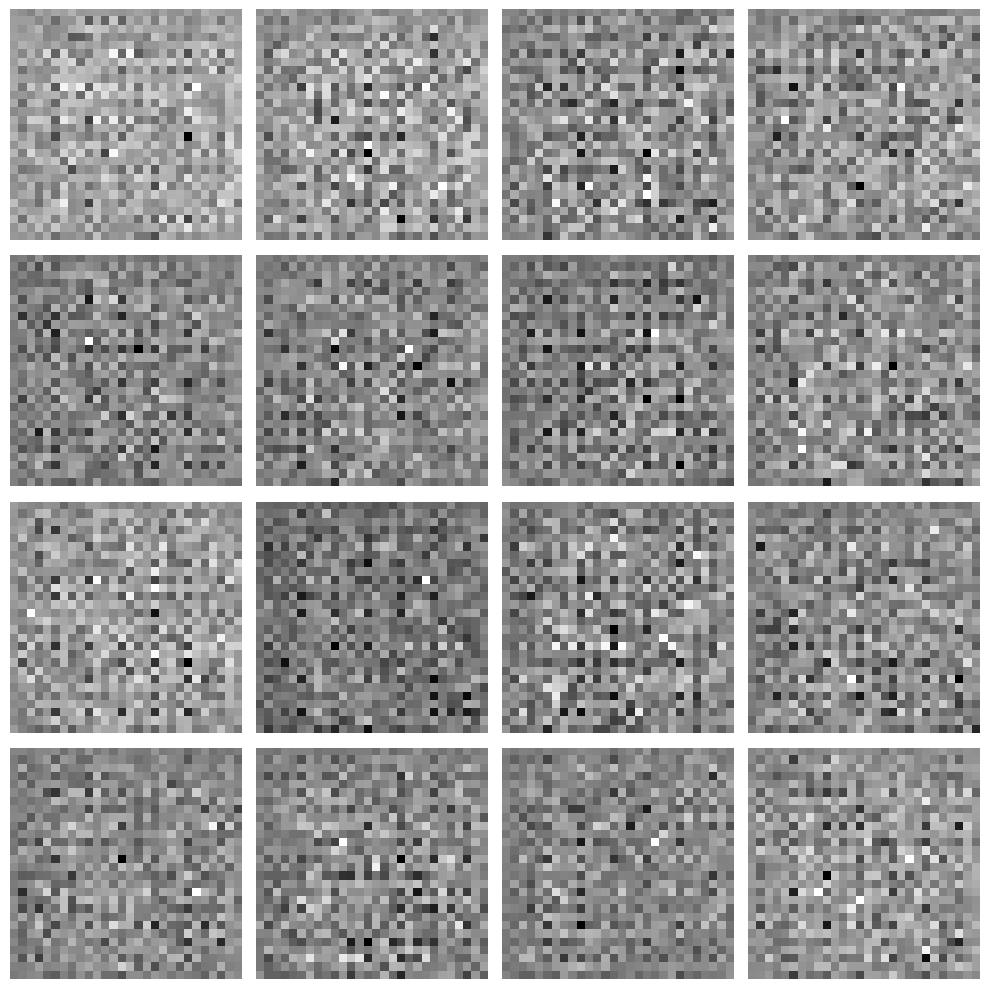

In [9]:
D =  discriminant()
tk.utils.plot_model(D, to_file='D.png', show_shapes=True, show_layer_names=True)

A = adversarial()
tk.utils.plot_model(A, to_file='A.png', show_shapes=True, show_layer_names=True)

G = generateur()
tk.utils.plot_model(G, to_file='G.png', show_shapes=True, show_layer_names=True)

myGAN(D,A,G)
plotImages(G,fake=True)
plotImages(G,fake=False, sauve=True)